# Unique species
Visualize the numbers of unique species within and across kingdoms.

In [1]:
import json
from collections import defaultdict, Counter
import sys
sys.path.append('../desiccation_network/build_citation_network/')
from classify_papers import map_specs_to_kings
import taxoniq
import pandas as pd
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import taxoniq
plt.rcParams['pdf.fonttype'] = 42

2024-05-03 15:06:14.443464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 15:06:14.633405: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Read in & preprocess data

In [2]:
graph = nx.read_graphml('../data/citation_network/FINAL_FINAL_DEBUGGED_MANUALLY_VERIFIED_core_collection_destol_or_anhydro_classified_network_29Mar2024.graphml')

In [3]:
with open('../data/citation_network/intermediate_saves/classmains_debug_30Jan2024/species_ids.json') as myf:
    species_ids = json.load(myf)

In [4]:
with open('../data/citation_network/intermediate_saves/classmains_debug_30Jan2024/paper_to_species.json') as myf:
    paper_to_species = json.load(myf)

In [5]:
# Cast all NCBI Taxonomy IDs to integers
species_ids = {k: int(v) for k, v in species_ids.items()}

## Numbers of unique species
### Entire dataset

In [6]:
total_uniq = set(species_ids.values())
print(f'There are {len(total_uniq)} unique species mentions in the overall dataset before processing to kingdoms.')

There are 4229 unique species mentions in the overall dataset before processing to kingdoms.


### Per class

In [7]:
full_species_dict = map_specs_to_kings(species_ids)

100%|██████████| 6458/6458 [00:00<00:00, 8146.24it/s] 

When building the species --> kingdom dict, 179 species were dropped because their kingdom wasn't in our list of interest, 3 were dropped because they were only identifyable as Eukaryota, and 15 because they did not appear in taxoniq's local version of NCBI Taxonomy. This could mean they are not in the actual taxonomy, or that they were added after taxoniq last updated its database version. Finally, 1 species were dropped because their lineage in the taxonomy entry was empty.


We want to disambiguate repeated species, we can do that by using their IDs:

In [8]:
unique_spec_kings = defaultdict(list)
for spec, king in full_species_dict.items():
    taxon_id = species_ids[spec]
    unique_spec_kings[king].append(taxon_id)
unique_spec_kings = {k: list(set(v)) for k, v in unique_spec_kings.items()}

We also want to make sure to remove any classifications above the species level, as these are both error prone and not directly mappable to specific species:

In [9]:
unique_spec_kings_filtered = {}
for king, specs in unique_spec_kings.items():
    king_specs = []
    for spec in specs:
        t = taxoniq.Taxon(spec)
        ranks = [t.rank.name for t in t.ranked_lineage]
        if ranks[0] == 'species':
            king_specs.append(spec)
    unique_spec_kings_filtered[king] = king_specs

In [10]:
for king, specs in unique_spec_kings_filtered.items():
    print(f'There are {len(specs)} unique database-normalized species in kingdom {king}.')

There are 874 unique database-normalized species in kingdom Animal.
There are 1429 unique database-normalized species in kingdom Plant.
There are 346 unique database-normalized species in kingdom Microbe.
There are 186 unique database-normalized species in kingdom Fungi.


In [11]:
print(f'There are {sum([len(v) for v in unique_spec_kings_filtered.values()])} total unique species across our kingdoms of interest.')

There are 2835 total unique species across our kingdoms of interest.


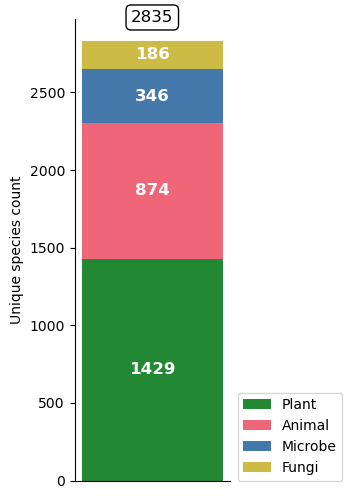

In [21]:
colors = {'Plant': '#228833', 'Animal':'#EE6677', 'Microbe': '#4477AA', 'Fungi':'#CCBB44'}
# Re-order dict
unique_spec_kings_filtered = {king: unique_spec_kings_filtered[king] for king in colors.keys()}
bottom = np.zeros(1)
fig, ax = plt.subplots(figsize=(2,6))
for king, specs in unique_spec_kings_filtered.items():
    count = len(specs)
    ax.bar('Dataset', count, color=colors[king], label=king, bottom=bottom)
    bottom += count
    
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        0.5*bar.get_height() + bar.get_y(),
        int(bar.get_height()),
        ha='center',
        va='center',
        color='w',
        weight='bold',
        size=12
    )
    
    centered_x = bar.get_x() + bar.get_width() / 2
    top_y = bar.get_height() + bar.get_y()

ax.text(centered_x, top_y + 100, sum([len(v) for v in unique_spec_kings_filtered.values()]), bbox={'boxstyle':'round', 'facecolor':'w'}, ha='center', va='bottom', fontsize=12)
ax.set_ylabel('Unique species count')
ax.spines[['right', 'top']].set_visible(False)
ax.get_xaxis().set_visible(False)
plt.legend(loc=(1.05,0))
plt.savefig('../data/citation_network/figures/fig_1C.pdf', format='pdf', dpi=600, bbox_inches='tight')

Let's make a bar graph of the top ten species mentions for each kingdom:

In [13]:
unique_species_mentions = []
for paper, species_names in paper_to_species.items():
    spec_ids = []
    for spec_name in species_names:
        try:
            spec_id = species_ids[spec_name]
            spec_ids.append(spec_id)
        except KeyError: # For species names unidentifiable with taxoniq
            continue
    unique_species_mentions.extend(list(set(spec_ids)))

In [14]:
ncbi_to_king = {species_ids[sp]: king for sp, king in full_species_dict.items()}

In [15]:
unique_mentions_by_king = defaultdict(list)
dropped = 0
for spec in unique_species_mentions:
    try:
        king = ncbi_to_king[spec]
        unique_mentions_by_king[king].append(spec)
    except KeyError:
        dropped += 1
print(f'{dropped} of {len(unique_species_mentions)} mentions were dropped because they did not have a kingdom.')

428 of 11360 mentions were dropped because they did not have a kingdom.


In [16]:
counted_mentions = {k: Counter(v) for k, v in unique_mentions_by_king.items()}

In [17]:
top_thirtys = {k: v.most_common(30) for k, v in counted_mentions.items()}

In [18]:
top_thirtys_filtered = {
    k: [i for i in v if [t.rank.name for t in taxoniq.Taxon(i[0]).ranked_lineage][0] == 'species']
    for k, v in top_thirtys.items()
}

In [19]:
top_thirtys_semantic = {k: {f'{taxoniq.Taxon(tid).scientific_name} ({tid})': num for tid, num in v} for k, v in top_thirtys_filtered.items()}

In [20]:
top_tens_semantic = {}
for king, tops in top_thirtys_semantic.items():
    king_top_ten = {}
    for i, pair in enumerate(tops.items()):
        if i < 10:
            king_top_ten[pair[0]] = pair[1]
    top_tens_semantic[king] = king_top_ten

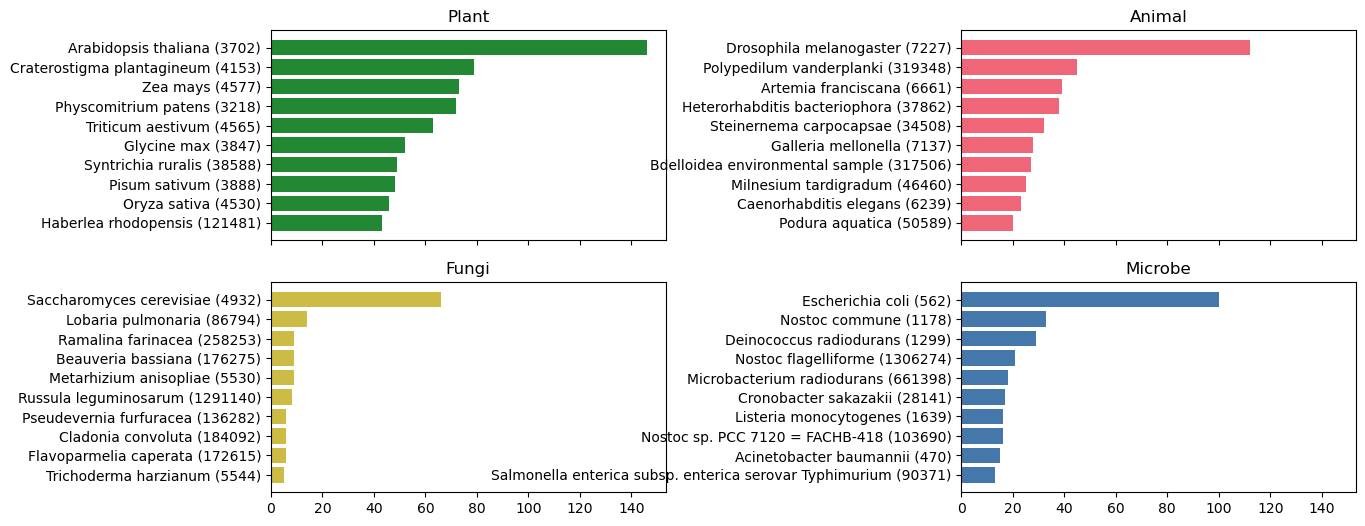

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(14,6), sharex=True)

for king, ax in zip(top_tens_semantic.keys(), axs.reshape(-1)):
    color = colors[king]
    specs = list(top_tens_semantic[king].keys())
    vals = list(top_tens_semantic[king].values())
    specs.reverse()
    vals.reverse()
    ax.barh(specs, vals, color=color)
    ax.set_title(king)
plt.subplots_adjust(wspace=0.75)
plt.savefig('../data/citation_network/figures/fig_1E-H.pdf', format='pdf', dpi=600, bbox_inches='tight')

## Papers per kingdom
We want a similar plot, but for papers instead of species.

In [23]:
papers_per_king = defaultdict(int)
for node, attrs in graph.nodes(data=True):
    papers_per_king[attrs['study_system']] += 1

In [24]:
papers_per_king

defaultdict(int, {'Plant': 3181, 'Animal': 1221, 'Microbe': 519, 'Fungi': 198})

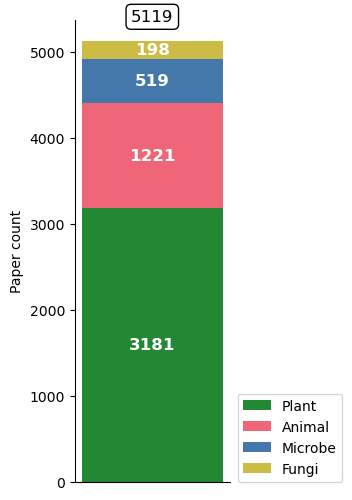

In [25]:
colors = {'Plant': '#228833', 'Animal':'#EE6677', 'Microbe': '#4477AA', 'Fungi':'#CCBB44'}
bottom = np.zeros(1)
fig, ax = plt.subplots(figsize=(2,6))
for king, pprs in papers_per_king.items():
    ax.bar('Dataset', pprs, color=colors[king], label=king, bottom=bottom)
    bottom += pprs

top_y = 0
for bar in ax.patches:
    top_y += bar.get_height()
#     if int(bar.get_height()) == 130:
#         fung_y =  bar.get_y()
#         top_y = bar.get_height() + fung_y
#         continue
#     else:
    ax.text(
            bar.get_x() + bar.get_width() / 2,
            0.5*bar.get_height() + bar.get_y(),
            int(bar.get_height()),
            ha='center',
            va='center',
            color='w',
            weight='bold',
            size=12
        )
    
    centered_x = bar.get_x() + bar.get_width() / 2

# obj = ax.text(0.75, fung_y, papers_per_king['Fungi'], bbox={'boxstyle':'round', 'facecolor':colors['Fungi'], 'edgecolor':'w'}, ha='center', va='bottom', fontsize=12, color='w', weight='bold')
# box = obj.get_bbox_patch()
# fig.canvas.draw()
# coords = ax.transData.inverted().transform(box.get_window_extent())
# x = coords[0][0]
# y = coords[1][1] - coords[0][1]
# ax.arrow(x, y, -0.25, 0)
ax.text(centered_x, top_y + 200, sum(papers_per_king.values()), bbox={'boxstyle':'round', 'facecolor':'w'}, ha='center', va='bottom', fontsize=12)
ax.set_ylabel('Paper count')
ax.spines[['right', 'top']].set_visible(False)
ax.get_xaxis().set_visible(False)
plt.legend(loc=(1.05,0))
plt.savefig('../data/citation_network/figures/fig_1B.pdf', format='pdf', dpi=600, bbox_inches='tight')

## Papers versus species in each category

In [26]:
num_papers = defaultdict(int)
for node, attrs in graph.nodes(data=True):
    num_papers[attrs['study_system']] += 1

In [27]:
uniq_spec_nums = {k: len(v) for k, v in unique_spec_kings_filtered.items()}

In [28]:
uniq_spec_nums_normed = {k: v/sum(uniq_spec_nums.values()) for k, v in uniq_spec_nums.items()}
num_papers_normed = {k: v/sum(num_papers.values()) for k, v in num_papers.items()}

In [29]:
uniq_spec_nums_normed

{'Plant': 0.5040564373897707,
 'Animal': 0.308289241622575,
 'Microbe': 0.12204585537918872,
 'Fungi': 0.0656084656084656}

In [30]:
num_papers_normed

{'Plant': 0.6214104317249463,
 'Animal': 0.23852314905254932,
 'Microbe': 0.10138698964641532,
 'Fungi': 0.03867942957608908}

In [31]:
bars_df = pd.DataFrame.from_dict(num_papers_normed, orient='index', columns=['Papers'])

In [32]:
bars_df = bars_df.merge(pd.DataFrame.from_dict(uniq_spec_nums_normed, orient='index', columns=['Species']), right_index=True, left_index=True)

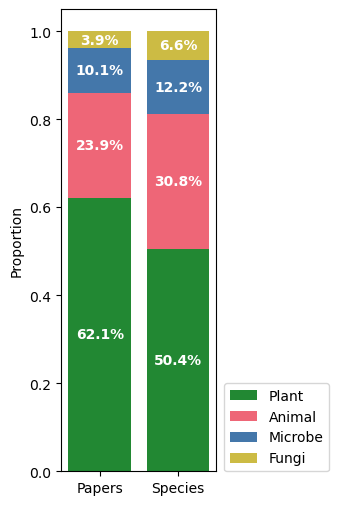

In [33]:
fig, ax = plt.subplots(figsize=(2,6))
bottom = np.zeros(bars_df.shape[1])

for system in bars_df.index:
    p = ax.bar(bars_df.columns.astype(str), bars_df.loc[system], color=colors[system], label=system, bottom=bottom)
    bottom += bars_df.loc[system]

for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        0.5*bar.get_height() + bar.get_y(),
        str(round(bar.get_height()*100, 1)) + '%',
        ha='center',
        va='center',
        color='w',
        weight='bold',
        size=10
    )
    
    centered_x = bar.get_x() + bar.get_width() / 2
    top_y = bar.get_height() + bar.get_y()

    
ax.set_ylabel('Proportion')
plt.legend(loc=(1.05,0))
plt.savefig('../data/citation_network/figures/fig_1D.pdf', format='pdf', dpi=600, bbox_inches='tight')